Overlap-save (OLS)
--> See Word journal week25 2022, TUE.

In [1]:
# Imports
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

In [2]:
# Constants
SEED = 12345    # random generator seed
N = 2**11       # FFT size (chunk length)
ovlp = .5       # frames overlap
L = 10          # broadcast length
T = 0.2          # duration [s]

# Random generator
rng = np.random.default_rng(SEED)

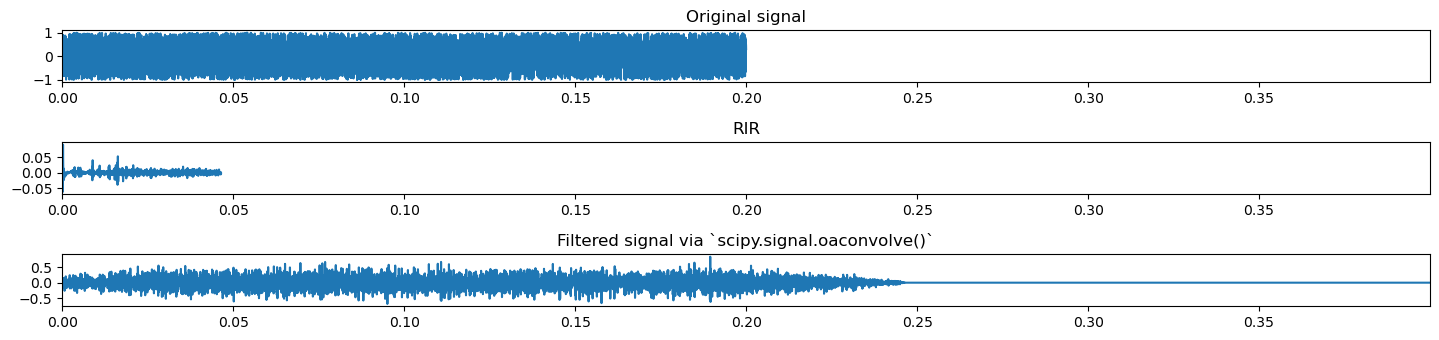

In [3]:
# Build signals

# Load an RIR
path = 'U:/py/sounds-phd/97_tests/05_dsp_related/00_signals/rir1.wav'
h, fs = sf.read(path)
h = h[:N]   # truncate

# Generate a chunk of (real - time-domain) multichannel signal
y = 2 * rng.random(int(T * fs)) - 1

# Ground truth filtered signal
# gt = sig.oaconvolve(y, h, axes=0)
gt = sig.fftconvolve(y, np.concatenate((h, np.zeros(len(y) - len(h)))))

# Plot
fig, axes = plt.subplots(3,1)
fig.set_size_inches(14.5, 3.5)
axes[0].plot(np.arange(len(y))/fs, y)
axes[0].set_title('Original signal')
axes[0].set_xlim([0, len(gt)/fs])
axes[1].plot(np.arange(len(h))/fs, h)
axes[1].set_title('RIR')
axes[1].set_xlim([0, len(gt)/fs])
axes[2].plot(np.arange(len(gt))/fs, gt)
axes[2].set_title('Filtered signal via `scipy.signal.oaconvolve()`')
axes[2].set_xlim([0, len(gt)/fs])
plt.tight_layout()	
plt.show()


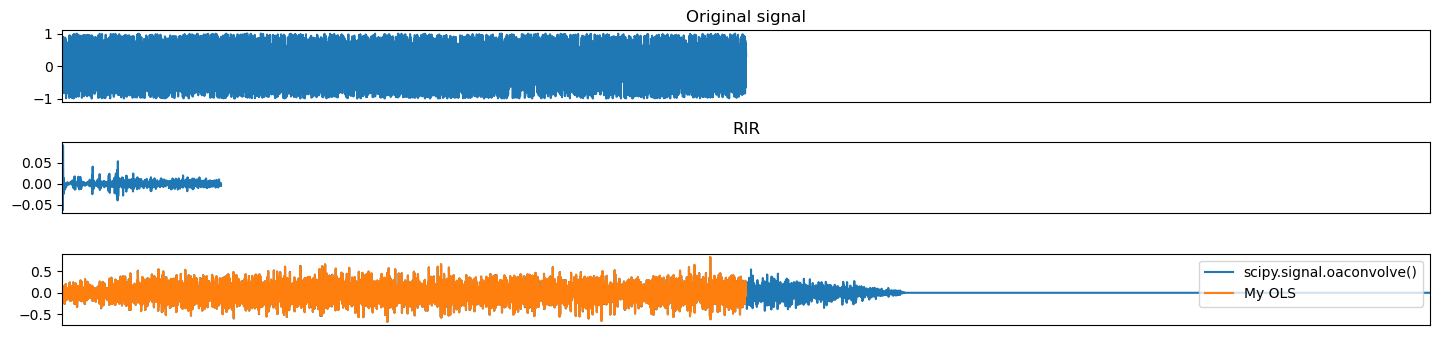

In [4]:
# OLS processing

# Compute transfer function
H = np.fft.fft(h, N)

out = []

flagstop = False
chunkidx = 0
while not flagstop:

    idxend = int((chunkidx + 1) * L)
    idxbeg = int(idxend - N)
    # print(f'Chunk: [{idxbeg}:{idxend}]')

    # Get data chunk
    if idxbeg < 0:
        ychunk = np.concatenate((np.zeros(N - idxend), y[0:idxend]))
    else:
        ychunk = y[idxbeg:idxend]

    # Go to freq. domain
    Ychunk = np.fft.fft(ychunk, N)

    # Filter chunk
    YchunkFiltered = Ychunk * H

    # Go back to time domain
    ychunkFiltered = np.fft.ifft(YchunkFiltered, N)
    ychunkFiltered = np.real_if_close(ychunkFiltered)

    # Save last `L` samples (discard the rest)
    out += list(ychunkFiltered[-L:])

    chunkidx += 1

    if (chunkidx + 1) * L > len(y):
        flagstop = True

# PLOT
fig, axes = plt.subplots(3,1)
fig.set_size_inches(14.5, 3.5)
axes[0].plot(np.arange(len(y))/fs, y)
axes[0].set_title('Original signal')
axes[0].set_xlim([0, len(gt)/fs])
axes[0].set_xticks([])
axes[1].plot(np.arange(len(h))/fs, h)
axes[1].set_title('RIR')
axes[1].set_xlim([0, len(gt)/fs])
axes[1].set_xticks([])
axes[2].plot(np.arange(len(gt))/fs, gt, label='scipy.signal.oaconvolve()')
axes[2].plot(np.arange(len(out))/fs, out, label='My OLS')
axes[2].set_xlim([0, len(gt)/fs])
axes[2].set_xticks([])
plt.legend()
plt.tight_layout()	
plt.show()